In [1]:
# NB: per eseguire questo notebook come file Python, scegliere il menù "File -> Download as -> Python (.py)" .
# Da Canopy, scommentando questa istruzione si hanno i grafici nella console e non in finestre aggiuntive:
#get_ipython().magic(u'matplotlib inline')
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def givens(xp,xq,p,n):
    G = np.eye(n+1)
    if xq == 0:
        c=1; s=0;
    elif abs(xq)>abs(xp):
        r = xp/xq; s = -1/np.sqrt(1+r**2); c=-s*r;
    else:
        r = xq/xp; c = 1/np.sqrt(1+r**2); s=-c*r;
    G[p,p] = c
    G[p,n] = -s
    G[n,p] = s
    G[n,n] = c
    return G

def recursive_qr(Q,R):
    n = len(Q[0:])+1
    N = len(R[-1,:])
    updQ = np.zeros((n,n))
    updQ[n-1,n-1] = 1
    updQ[:n-1,:n-1] = Q
    updR = R
    for i in range(N):
        G = givens(R[i,i],R[-1,i],i,n-1)
        updQ = updQ @ G.T
        updR = G @ updR
    return updQ,updR

In [3]:
esercizio = 1

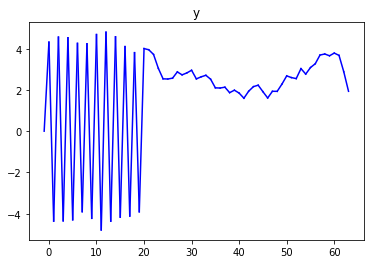

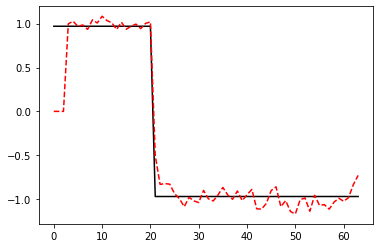

In [4]:
# definiamo un sistema del primo ordine:
a = np.array([1., 0.97])
na = len(a) - 1
b = np.array([4.])
# condizioni iniziali :
u_m1 = 0.
y_m1 = 0.
y_m2 = 0.
# scelgo se aggiungere il rumore ai dati:
aggiungo_rumore = True
# coefficiente di oblio (lambda):
lam = 0.5  # 0.5 - 0.99
Ndati = 64
u = np.zeros(Ndati)
y = np.zeros(Ndati)
plt.figure(1); plt.title('y');
a_est = np.zeros((na,Ndati))
a_hist = np.zeros((na+1,Ndati))
w = np.random.randn(Ndati)

for N in range(Ndati):
  #print("N = ",N)
  # legge di variazione dei parametri:
  if N>20: a[1] = -0.97 #endif 
  a_hist[1,N] = a[1]
  # calcolo l'ingresso (sequenza di kronecker):
  if N==0: 
    u[N]=1. 
  else: 
    u[N]=0. 
  #endif
  # aggiorno l'uscita del sistema 
  y[N] = 1./a[0] * ( -a[1]*y_m1 + b[0]*u[N] )     #sarebbe h cioè la risposta all'impulso discreto
  if aggiungo_rumore:
    y[N] = y[N] + 0.3*w[N]   # 0.3
  #endif
  plt.plot([N-1, N],[y_m1, y[N]],'b-'); 
  # calcolo/aggiorno le stime
  #ricorda: risolviamo il sistema H*a=-h dove la matrice H parte da h_1 e -h=[-h_na+1 ... -h_N] che viene da H(grande)*a(con -1 in fondo)=0
  istante_prima_stima = (na+1)+na
  if N > istante_prima_stima:
    d = lam * d;   #aggiungiamo il fattore di oblio
    d = np.vstack((d, -y[N]))
    
    R = lam * R
    R = np.vstack((R, y[N-na:N-1+1])) 
    
    if esercizio == 1:
        Q,R = recursive_qr(Q.copy(),R.copy())
        a_est[:,N] = np.linalg.solve( R[:na,:] , Q[:,:na].T@d )
    elif esercizio == 2:
        lung = len(Q[0:])+1
        Qtemp = Q
        Q = np.zeros((lung,lung))
        Q[lung-1,lung-1] = 1
        Q[:lung-1,:lung-1] = Qtemp
        Qtd = Q.T @ d
        for i in range(na):
            G = givens(R[i,i],R[-1,i],i,lung-1)
            Qtd = G @ Qtd
            R = G @ R
        a_est[:,N] = np.linalg.solve( R[:na,:] , Qtd[:na,:] )      
    
  elif N == istante_prima_stima: # calcolo la prima volta, risolvendo il sistema (10.2.10)
                         # (NB: è >= al primo "N" per cui la matrice del sistema risulti quadrata)
    A = np.vstack((A, y[N-na:N-1+1])) 
    d = np.vstack((d, -y[N]))
    Q,R = np.linalg.qr(A.copy(),mode='complete') #la prima QR va fatta poi dal prossimo sarà ricorsivo
    a_est[0,N] = np.linalg.solve( R[:na,:] , Q[:,:na].T@d )
  elif N > na+1:
    A = np.vstack((A, y[N-na:N-1+1])) #stackiamo finchè non abbiamo abbastanza dati
    d = np.vstack((d, -y[N]))
  elif N == na+1:
    A = y[N-na:N-1+1] #da h_1 a h_na, creiamo
    d = np.array(-y[N])
  #endif
  # aggiorno gli elementi di ritardo (NB: da quello più lontano nel tempo !!!)
  u_m1 = u[N]
  y_m2 = y_m1
  y_m1 = y[N]
#endfor

plt.figure(10);  
plt.plot(np.squeeze(np.array(a_hist[1,:])),'k')
plt.plot(np.squeeze(np.array(a_est[0,:])),'r--')
plt.show()